## This file trains models defined in parameters.csv and output a .h5 weight file for each model. It also records the training procedure and some key benchmarks to evaluate the models in output.csv, accuracy folder and loss folder

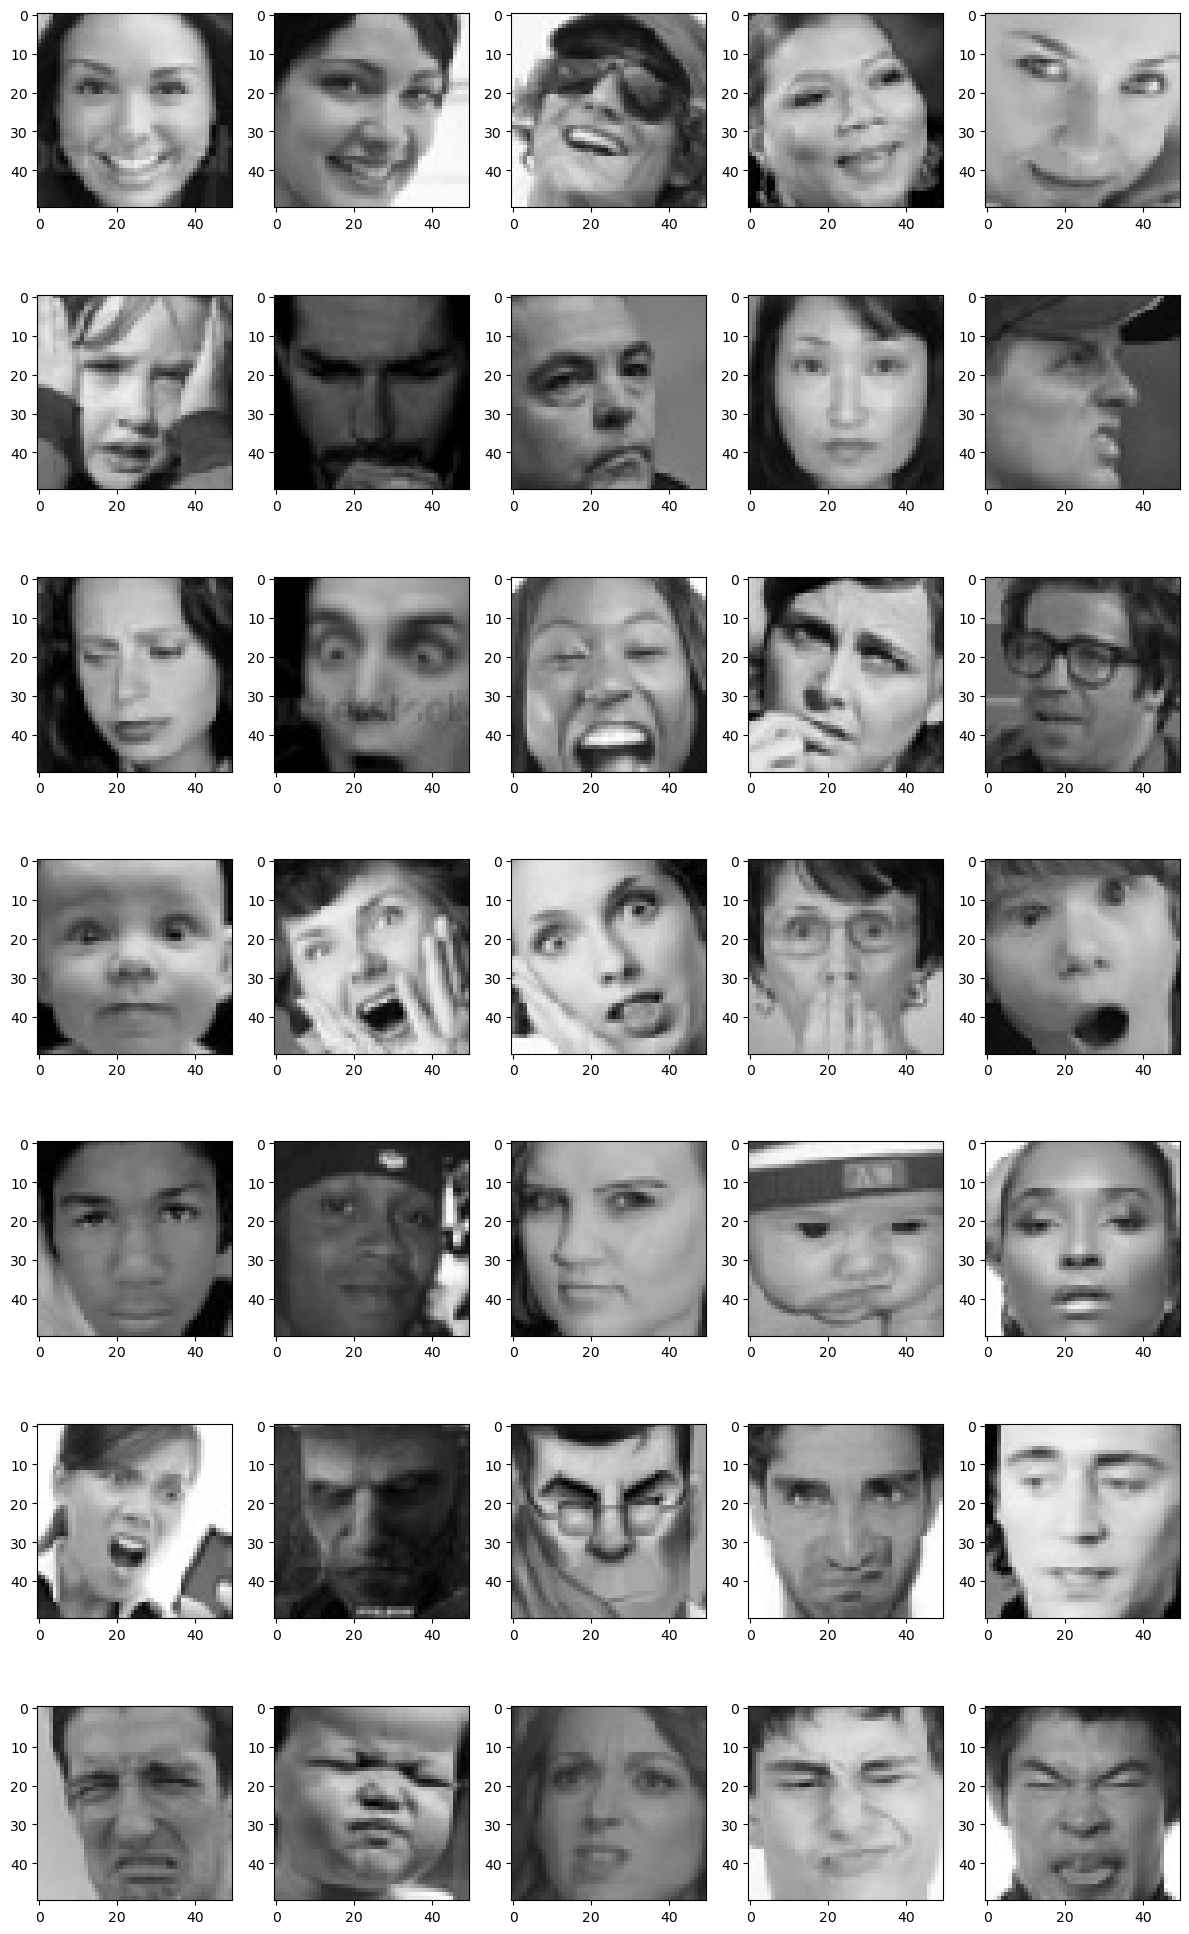

In [99]:
from keras.utils import load_img
import matplotlib.pyplot as plt
import os
from initiate_model import initiate_model

# This is the size of image we want to show
img_size = 50
# The path to the dataset
base_path = "resources/images/"

# This part gives a preview of the dataset to show that the dataset works properly and are not corrupted
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    if not os.path.isdir(base_path + "train/" + expression):
        continue
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

## Image augmentation using keras ImageDataGenerator

In [100]:
from keras.preprocessing.image import ImageDataGenerator
# The number of processed images per batch
batch_size = 128
pic_size = 56

# This part transforms the raw images into dataset to process
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 7066 images belonging to 7 classes.
Found 3173 images belonging to 7 classes.


In [101]:
# This part plots the loss and accuracy figures for one model and save them under the corresponding folders.
def plot_results(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if not os.path.exists('accuracy'):
        os.makedirs('accuracy')

    if not os.path.exists('loss'):
        os.makedirs('loss')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.savefig('accuracy/{}.png'.format(name))


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.savefig('loss/{}.png'.format(name))

    plt.show()

# This method finds on which epoch does the model hits the best accuracy. This helps us to find the best point to terminate training
def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

In [102]:
from keras.callbacks import Callback
import time
# This is a callback function which executes at the end of each epoch. It records the key benchmarks of this model and keeps updating it 
class DataCallback(Callback):
    def __init__(self):
        super(DataCallback, self).__init__()
        self.training_start_time = time.time()
        self.accuracy_50_time = -1
        self.best_accuracy = 0
    def on_epoch_end(self, epoch, logs={}):
        self.best_accuracy = max(self.best_accuracy, logs.get('val_accuracy'))
        if logs.get('val_accuracy') >= 0.5:
            self.accuracy_50_time = min(time.time() - self.training_start_time, self.accuracy_50_time)
    def on_train_end(self, logs=None):
        self.training_consumed_time = time.time() - self.training_start_time

In [103]:
from keras.callbacks import ModelCheckpoint
import csv

# The relative path of the output benchmark file
CSV_NAME = 'output.csv'

# Train a specified model with the provided dataset
def train(name, conv_num, fc_num, conv_filters_num, conv_filters_size, pool_size, pool_pos, dropout, fc_denses_num, lr):
    print("Currently processing {}".format(name))
    model = initiate_model(conv_num, fc_num, conv_filters_num, conv_filters_size, pool_size, dropout, fc_denses_num, lr)
    # The number of epochs to train the model
    epochs = 3
    # Defines the weight file and when to update the weight file.
    checkpoint = ModelCheckpoint(name + "_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    data_callback = DataCallback()
    # Update the weight file and update the key benchmark record
    callbacks_list = [checkpoint, data_callback]

    history = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                                    epochs=epochs,
                                    validation_data = validation_generator,
                                    validation_steps = validation_generator.n//validation_generator.batch_size,
                                    callbacks=callbacks_list
                                    )

    plot_results(name, history)
    best_epoch = get_best_epcoh(history)
    time_consumed = data_callback.training_consumed_time
    reach_50_time_consumed = data_callback.accuracy_50_time

    to_write = [name, conv_num, fc_num, conv_filters_num, conv_filters_size, pool_size, dropout, fc_denses_num, lr, best_epoch, time_consumed, reach_50_time_consumed]
    with open(CSV_NAME, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
    
        writer.writerow(to_write)

In [104]:
import ast
# Train a model for each row in parameters.csv
def train_all():
    with open(CSV_NAME, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        title = ['name', 'conv_num', 'fc_num', 'conv_filters_num', 'conv_filters_size', 'pool_size', 'dropout', 'fc_denses_num', 'lr', 'best_epoch', 'finish_time_consumed', 'reach_50_time_consumed']
        writer.writerow(title)

    parameter_filename = 'parameters.csv'
    with open(parameter_filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')

        next(reader)

        for row in reader:
            if len(row) != 10:
                print("Wrong number of parameters")
            row_data = []
            for field in row:
                try:
                    field = ast.literal_eval(field)
                except ValueError:
                    pass
                row_data.append(field)
            train(*row_data)

    

In [105]:
train_all()

Currently processing VGG-Face


ValueError: Exception encountered when calling layer "max_pooling2d_75" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_75/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,256].

Call arguments received by layer "max_pooling2d_75" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 256), dtype=float32)